In [6]:
from sklearn.metrics import  roc_auc_score, classification_report, roc_curve, auc
from sklearn.model_selection import train_test_split


import pandas as pd
from fastparquet import ParquetFile
import numpy as np

import shap
from utils import feature_drop, remove_highly_correlated_features, get_shap_feature, get_categorical_columns

from catboost import CatBoostClassifier, Pool
from xgboost import XGBClassifier
import lightgbm as lgb

import seaborn as sns
import matplotlib.pyplot as plt
colors = ["#A115FE", "#8F00FF", "#4d0585", "#591878", "#6e1f78", "#7b469c", "#2c0652",
          "#29AB50", "#22753b", "#ECE919", "#7a781d", "#0F91D0", "#0f3f75"]
sns.set_palette(sns.color_palette(colors))

In [7]:
file_path = "Data/train_ai_comp_final_dp.parquet"
pf = ParquetFile(file_path)
df = pf.to_pandas()
df = feature_drop(df)
df.head()

,id,target,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,...,feature1067,feature1068,feature1069,feature1070,feature1071,feature1072,feature1073,feature1074,feature1075,feature1076
0,0,0,1761,1759,85,105469,191,46,0,6,...,28913,48985,84264,12045,12107,12510,21126,28913,48985,84264
1,1,0,1761,1759,120,105610,144,71,0,135,...,0,0,0,0,0,0,0,0,0,0
2,2,0,890,1759,141,105227,191,11,0,0,...,55949,70006,113317,33735,31242,12691,48682,55949,70006,113317
5,5,0,1599,966,30,102441,191,8,0,0,...,0,6872,8530,0,0,0,0,0,6872,8530
6,6,0,1761,1759,85,104006,191,2,0,0,...,0,0,7642,0,0,0,0,0,0,7642


In [8]:
X = df.drop(columns=['target', "id"])
y = df['target']
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.1, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [9]:
X_train.head()

,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,feature10,...,feature1067,feature1068,feature1069,feature1070,feature1071,feature1072,feature1073,feature1074,feature1075,feature1076
187083,1761,1759,117,105345,191,152,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
585908,1761,1759,88,74109,191,6,125,290,298,176,...,0,0,0,0,0,0,0,0,0,0
241239,1630,601,105,104480,191,34,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
175984,1639,17,86,102228,0,12,125,290,298,176,...,0,0,0,0,0,0,0,0,0,0
393146,1761,1759,32,82893,191,44,125,290,298,176,...,0,0,0,0,0,0,0,0,0,0


In [10]:
classifiers = [
    lgb.LGBMClassifier(n_estimators=50, random_state=42, max_depth=8, learning_rate=0.01),
    XGBClassifier(n_estimators=50, random_state=42, max_depth=8, learning_rate=0.01),
    CatBoostClassifier(iterations=50, learning_rate=0.01, depth=8, loss_function='Logloss', verbose=500)
]
shap_df  = get_shap_feature(X_train, y_train, X_val, classifiers)


c:\Users\Александр\Desktop\УЧЕБА\ХАКАТОНЫ\IT Purple Hack\purple_hack\venv\Lib\site-packages\shap\explainers\_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


0:	learn: 0.6777154	total: 758ms	remaining: 37.2s
49:	learn: 0.2795179	total: 25.1s	remaining: 0us


In [11]:
shap_df.sort_values(by = "shap_importance", ascending = False)

,feature,shap_importance
574,feature994,4.288690e-02
203,feature341,2.483448e-02
192,feature319,2.418532e-02
6,feature1004,2.386159e-02
560,feature954,1.294682e-02
...,...,...
324,feature51,3.749350e-07
165,feature27,2.174389e-07
523,feature910,2.006125e-07
507,feature889,1.438104e-07


In [12]:
feature = shap_df["feature"].values
X_test, X_train, X_val = X_test[feature], X_train[feature], X_val[feature]

In [13]:
without_drop = shap_df.sort_values(by = "shap_importance", ascending = False)["feature"].head(10)
without_drop.values

array(['feature994', 'feature341', 'feature319', 'feature1004',
       'feature954', 'feature953', 'feature940', 'feature920',
       'feature713', 'feature952'], dtype=object)

In [14]:
X_train.shape

(467653, 578)

In [15]:
columns_to_remove = remove_highly_correlated_features(X_train.drop(columns=without_drop.values), shap_df, threshold=0.92)

In [16]:
columns_to_remove = remove_highly_correlated_features(X_train.drop(columns=without_drop.values), shap_df, threshold=0.92)

In [17]:
X_train, X_val, X_test = X_train.drop(columns=columns_to_remove), X_val.drop(columns=columns_to_remove),  X_test.drop(columns=columns_to_remove)

In [13]:
X_train.shape

(467653, 411)

In [18]:
category = get_categorical_columns(X_train)

In [14]:
len(category)

49

In [15]:
len(category)

32

In [16]:
set1 = set(category)
set2 = set(X_train.columns)

is_subset = set1.issubset(set2)

is_subset

True

In [37]:
params = {'iterations': 999, 'learning_rate': 0.08141778879314024, 'depth': 8, 'l2_leaf_reg': 13.085427934255682, 'random_strength': 0.00024998050498273446}

[I 2024-03-13 10:23:19,830] A new study created in memory with name: no-name-280158b5-a0aa-4490-9321-7984cfca81c2
/tmp/ipykernel_138387/2637116355.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
/tmp/ipykernel_138387/2637116355.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-8, 100),
/tmp/ipykernel_138387/2637116355.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'rando

0:	learn: 0.6912189	test: 0.6912177	best: 0.6912177 (0)	total: 846ms	remaining: 6m 22s
200:	learn: 0.4142668	test: 0.4141248	best: 0.4141248 (200)	total: 2m 23s	remaining: 3m
400:	learn: 0.2819587	test: 0.2817143	best: 0.2817143 (400)	total: 4m 46s	remaining: 37.1s
452:	learn: 0.2605265	test: 0.2602631	best: 0.2602631 (452)	total: 5m 23s	remaining: 0us
bestTest = 0.2602631404
bestIteration = 452


[I 2024-03-13 10:28:51,382] Trial 0 finished with value: 0.7230019746353203 and parameters: {'iterations': 453, 'learning_rate': 0.001188866737123741, 'depth': 6, 'l2_leaf_reg': 1.7372551125428e-08, 'random_strength': 0.004702033595871019}. Best is trial 0 with value: 0.7230019746353203.


0 0.7230019746353203


/tmp/ipykernel_138387/2637116355.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
/tmp/ipykernel_138387/2637116355.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-8, 100),
/tmp/ipykernel_138387/2637116355.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'random_strength': trial.suggest_loguniform('random_strength', 1e-8, 1.0),


0:	learn: 0.6913173	test: 0.6913174	best: 0.6913174 (0)	total: 904ms	remaining: 3m 23s
200:	learn: 0.4266329	test: 0.4268825	best: 0.4268825 (200)	total: 3m 1s	remaining: 22.6s
225:	learn: 0.4047136	test: 0.4049974	best: 0.4049974 (225)	total: 3m 23s	remaining: 0us
bestTest = 0.4049973909
bestIteration = 225


[I 2024-03-13 10:32:22,366] Trial 1 finished with value: 0.7245160894019039 and parameters: {'iterations': 226, 'learning_rate': 0.0010965694497740656, 'depth': 9, 'l2_leaf_reg': 0.0031115892576067845, 'random_strength': 4.2410745198621446e-07}. Best is trial 1 with value: 0.7245160894019039.


1 0.7245160894019039


/tmp/ipykernel_138387/2637116355.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
/tmp/ipykernel_138387/2637116355.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-8, 100),
/tmp/ipykernel_138387/2637116355.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'random_strength': trial.suggest_loguniform('random_strength', 1e-8, 1.0),


0:	learn: 0.6710205	test: 0.6710497	best: 0.6710497 (0)	total: 1s	remaining: 6m 18s
200:	learn: 0.1340440	test: 0.1406032	best: 0.1406032 (200)	total: 3m 21s	remaining: 2m 58s
378:	learn: 0.1275529	test: 0.1383793	best: 0.1383793 (378)	total: 6m 20s	remaining: 0us
bestTest = 0.1383792896
bestIteration = 378


[I 2024-03-13 10:38:50,834] Trial 2 finished with value: 0.7363565456354477 and parameters: {'iterations': 379, 'learning_rate': 0.013402014590695613, 'depth': 10, 'l2_leaf_reg': 2.3031728752941413e-06, 'random_strength': 0.0036129598200933433}. Best is trial 2 with value: 0.7363565456354477.


2 0.7363565456354477


/tmp/ipykernel_138387/2637116355.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
/tmp/ipykernel_138387/2637116355.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-8, 100),
/tmp/ipykernel_138387/2637116355.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'random_strength': trial.suggest_loguniform('random_strength', 1e-8, 1.0),


0:	learn: 0.6837893	test: 0.6837794	best: 0.6837794 (0)	total: 579ms	remaining: 8m 24s
200:	learn: 0.1678514	test: 0.1672225	best: 0.1672225 (200)	total: 1m 56s	remaining: 6m 28s
400:	learn: 0.1437110	test: 0.1432261	best: 0.1432261 (400)	total: 3m 52s	remaining: 4m 32s
600:	learn: 0.1407268	test: 0.1404900	best: 0.1404900 (600)	total: 5m 47s	remaining: 2m 36s
800:	learn: 0.1397553	test: 0.1397536	best: 0.1397536 (800)	total: 7m 43s	remaining: 41.1s
871:	learn: 0.1395168	test: 0.1395809	best: 0.1395809 (871)	total: 8m 25s	remaining: 0us
bestTest = 0.1395808918
bestIteration = 871


[I 2024-03-13 10:47:22,995] Trial 3 finished with value: 0.7303252116176416 and parameters: {'iterations': 872, 'learning_rate': 0.005817475685839636, 'depth': 4, 'l2_leaf_reg': 0.006158698282324313, 'random_strength': 1.8531210147459814e-05}. Best is trial 2 with value: 0.7363565456354477.


3 0.7303252116176416


/tmp/ipykernel_138387/2637116355.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
/tmp/ipykernel_138387/2637116355.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-8, 100),
/tmp/ipykernel_138387/2637116355.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'random_strength': trial.suggest_loguniform('random_strength', 1e-8, 1.0),


0:	learn: 0.6080772	test: 0.6079834	best: 0.6079834 (0)	total: 575ms	remaining: 7m 16s
200:	learn: 0.1378135	test: 0.1386962	best: 0.1386962 (200)	total: 1m 55s	remaining: 5m 22s
400:	learn: 0.1361100	test: 0.1382206	best: 0.1382180 (396)	total: 3m 51s	remaining: 3m 28s
600:	learn: 0.1346991	test: 0.1379453	best: 0.1379393 (587)	total: 5m 47s	remaining: 1m 32s
760:	learn: 0.1337199	test: 0.1379068	best: 0.1378993 (674)	total: 7m 20s	remaining: 0us
bestTest = 0.1378992903
bestIteration = 674
Shrink model to first 675 iterations.


[I 2024-03-13 10:54:50,443] Trial 4 finished with value: 0.7423263991262239 and parameters: {'iterations': 761, 'learning_rate': 0.055494225764788685, 'depth': 4, 'l2_leaf_reg': 0.0007315946220151431, 'random_strength': 3.6398936407704123e-07}. Best is trial 4 with value: 0.7423263991262239.


4 0.7423263991262239


/tmp/ipykernel_138387/2637116355.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
/tmp/ipykernel_138387/2637116355.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-8, 100),
/tmp/ipykernel_138387/2637116355.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'random_strength': trial.suggest_loguniform('random_strength', 1e-8, 1.0),


0:	learn: 0.6911188	test: 0.6911223	best: 0.6911223 (0)	total: 1.01s	remaining: 11m 27s
200:	learn: 0.4064417	test: 0.4072315	best: 0.4072315 (200)	total: 3m 21s	remaining: 7m 58s
400:	learn: 0.2732260	test: 0.2746792	best: 0.2746792 (400)	total: 6m 41s	remaining: 4m 38s
600:	learn: 0.2083935	test: 0.2104886	best: 0.2104886 (600)	total: 10m 2s	remaining: 1m 18s
678:	learn: 0.1930174	test: 0.1953893	best: 0.1953893 (678)	total: 11m 20s	remaining: 0us
bestTest = 0.1953893049
bestIteration = 678


[I 2024-03-13 11:06:19,030] Trial 5 finished with value: 0.7246700921422747 and parameters: {'iterations': 679, 'learning_rate': 0.0012107843025438729, 'depth': 10, 'l2_leaf_reg': 8.20828176880269e-08, 'random_strength': 7.427815378477136e-06}. Best is trial 4 with value: 0.7423263991262239.


5 0.7246700921422747


/tmp/ipykernel_138387/2637116355.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
/tmp/ipykernel_138387/2637116355.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-8, 100),
/tmp/ipykernel_138387/2637116355.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'random_strength': trial.suggest_loguniform('random_strength', 1e-8, 1.0),


0:	learn: 0.6613870	test: 0.6613847	best: 0.6613847 (0)	total: 913ms	remaining: 6m 44s
200:	learn: 0.1366806	test: 0.1387633	best: 0.1387633 (200)	total: 3m	remaining: 3m 38s
400:	learn: 0.1337730	test: 0.1379173	best: 0.1379170 (396)	total: 6m	remaining: 38.7s
443:	learn: 0.1333307	test: 0.1378169	best: 0.1378167 (442)	total: 6m 39s	remaining: 0us
bestTest = 0.1378167469
bestIteration = 442
Shrink model to first 443 iterations.


[I 2024-03-13 11:13:05,794] Trial 6 finished with value: 0.7402659020639901 and parameters: {'iterations': 444, 'learning_rate': 0.01958308777412677, 'depth': 9, 'l2_leaf_reg': 46.11514026309692, 'random_strength': 1.638933248264611e-06}. Best is trial 4 with value: 0.7423263991262239.


6 0.7402659020639901


/tmp/ipykernel_138387/2637116355.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
/tmp/ipykernel_138387/2637116355.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-8, 100),
/tmp/ipykernel_138387/2637116355.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'random_strength': trial.suggest_loguniform('random_strength', 1e-8, 1.0),


0:	learn: 0.6507566	test: 0.6507435	best: 0.6507435 (0)	total: 836ms	remaining: 13m 51s
200:	learn: 0.1339816	test: 0.1384984	best: 0.1384984 (200)	total: 2m 47s	remaining: 11m
400:	learn: 0.1294126	test: 0.1377894	best: 0.1377894 (400)	total: 5m 33s	remaining: 8m 14s
600:	learn: 0.1257678	test: 0.1375499	best: 0.1375499 (600)	total: 8m 22s	remaining: 5m 30s
800:	learn: 0.1224801	test: 0.1373895	best: 0.1373895 (800)	total: 11m 11s	remaining: 2m 43s
995:	learn: 0.1193594	test: 0.1373782	best: 0.1373109 (966)	total: 13m 56s	remaining: 0us
bestTest = 0.137310887
bestIteration = 966
Shrink model to first 967 iterations.


[I 2024-03-13 11:27:10,521] Trial 7 finished with value: 0.7450724239976397 and parameters: {'iterations': 996, 'learning_rate': 0.026256714844353043, 'depth': 8, 'l2_leaf_reg': 1.089803384786932e-07, 'random_strength': 1.4529614210942658e-08}. Best is trial 7 with value: 0.7450724239976397.


7 0.7450724239976397


/tmp/ipykernel_138387/2637116355.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
/tmp/ipykernel_138387/2637116355.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-8, 100),
/tmp/ipykernel_138387/2637116355.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'random_strength': trial.suggest_loguniform('random_strength', 1e-8, 1.0),


0:	learn: 0.6702317	test: 0.6702157	best: 0.6702157 (0)	total: 720ms	remaining: 4m 21s
200:	learn: 0.1401898	test: 0.1405812	best: 0.1405812 (200)	total: 2m 24s	remaining: 1m 58s
364:	learn: 0.1375330	test: 0.1388493	best: 0.1388493 (364)	total: 4m 23s	remaining: 0us
bestTest = 0.1388492655
bestIteration = 364


[I 2024-03-13 11:31:42,059] Trial 8 finished with value: 0.7342877302763812 and parameters: {'iterations': 365, 'learning_rate': 0.014307501935720317, 'depth': 6, 'l2_leaf_reg': 4.876890857536299e-06, 'random_strength': 3.399105245515705e-05}. Best is trial 7 with value: 0.7450724239976397.


8 0.7342877302763812


/tmp/ipykernel_138387/2637116355.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
/tmp/ipykernel_138387/2637116355.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-8, 100),
/tmp/ipykernel_138387/2637116355.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'random_strength': trial.suggest_loguniform('random_strength', 1e-8, 1.0),


0:	learn: 0.6904005	test: 0.6903995	best: 0.6903995 (0)	total: 842ms	remaining: 13m 6s
200:	learn: 0.3477919	test: 0.3479363	best: 0.3479363 (200)	total: 2m 49s	remaining: 10m 19s
400:	learn: 0.2244646	test: 0.2248238	best: 0.2248238 (400)	total: 5m 38s	remaining: 7m 30s
600:	learn: 0.1767637	test: 0.1774057	best: 0.1774057 (600)	total: 8m 28s	remaining: 4m 42s
800:	learn: 0.1565206	test: 0.1574893	best: 0.1574893 (800)	total: 11m 18s	remaining: 1m 53s
934:	learn: 0.1496111	test: 0.1508048	best: 0.1508048 (934)	total: 13m 12s	remaining: 0us
bestTest = 0.1508047576
bestIteration = 934


[I 2024-03-13 11:45:03,725] Trial 9 finished with value: 0.726437037432992 and parameters: {'iterations': 935, 'learning_rate': 0.0016606914944349506, 'depth': 8, 'l2_leaf_reg': 2.222015415020985e-07, 'random_strength': 2.5775052990773255e-07}. Best is trial 7 with value: 0.7450724239976397.


9 0.726437037432992


/tmp/ipykernel_138387/2637116355.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
/tmp/ipykernel_138387/2637116355.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-8, 100),
/tmp/ipykernel_138387/2637116355.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'random_strength': trial.suggest_loguniform('random_strength', 1e-8, 1.0),


0:	learn: 0.5663161	test: 0.5661734	best: 0.5661734 (0)	total: 377ms	remaining: 6m 14s
200:	learn: 0.1329296	test: 0.1375903	best: 0.1375903 (200)	total: 2m 37s	remaining: 10m 18s
400:	learn: 0.1287042	test: 0.1372424	best: 0.1372424 (400)	total: 5m 11s	remaining: 7m 39s
600:	learn: 0.1250058	test: 0.1372255	best: 0.1371765 (489)	total: 7m 45s	remaining: 5m 3s
bestTest = 0.1371765348
bestIteration = 489
Shrink model to first 490 iterations.


[I 2024-03-13 11:55:22,373] Trial 10 finished with value: 0.747001359732817 and parameters: {'iterations': 993, 'learning_rate': 0.08923160316241886, 'depth': 7, 'l2_leaf_reg': 4.218357753286806, 'random_strength': 0.908377453233222}. Best is trial 10 with value: 0.747001359732817.


10 0.747001359732817


/tmp/ipykernel_138387/2637116355.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
/tmp/ipykernel_138387/2637116355.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-8, 100),
/tmp/ipykernel_138387/2637116355.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'random_strength': trial.suggest_loguniform('random_strength', 1e-8, 1.0),


0:	learn: 0.5752573	test: 0.5751257	best: 0.5751257 (0)	total: 349ms	remaining: 5m 37s
200:	learn: 0.1333496	test: 0.1375475	best: 0.1375475 (200)	total: 2m 33s	remaining: 9m 45s
400:	learn: 0.1293534	test: 0.1373148	best: 0.1373139 (398)	total: 5m 7s	remaining: 7m 13s
600:	learn: 0.1258443	test: 0.1371672	best: 0.1371437 (586)	total: 7m 41s	remaining: 4m 40s
800:	learn: 0.1228260	test: 0.1370818	best: 0.1370592 (785)	total: 10m 15s	remaining: 2m 6s
965:	learn: 0.1202165	test: 0.1370752	best: 0.1370297 (873)	total: 12m 22s	remaining: 0us
bestTest = 0.1370296783
bestIteration = 873
Shrink model to first 874 iterations.


[I 2024-03-13 12:07:52,264] Trial 11 finished with value: 0.7490370331693179 and parameters: {'iterations': 966, 'learning_rate': 0.08239801723593801, 'depth': 7, 'l2_leaf_reg': 4.121297895182485, 'random_strength': 0.8202344260693056}. Best is trial 11 with value: 0.7490370331693179.


11 0.7490370331693179


/tmp/ipykernel_138387/2637116355.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
/tmp/ipykernel_138387/2637116355.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-8, 100),
/tmp/ipykernel_138387/2637116355.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'random_strength': trial.suggest_loguniform('random_strength', 1e-8, 1.0),


0:	learn: 0.5593159	test: 0.5591642	best: 0.5591642 (0)	total: 341ms	remaining: 4m 39s
200:	learn: 0.1350239	test: 0.1376508	best: 0.1376494 (197)	total: 2m 22s	remaining: 7m 19s
400:	learn: 0.1329804	test: 0.1373467	best: 0.1373438 (382)	total: 4m 44s	remaining: 4m 58s
600:	learn: 0.1313258	test: 0.1372065	best: 0.1372056 (599)	total: 7m 6s	remaining: 2m 36s
800:	learn: 0.1300083	test: 0.1371562	best: 0.1371480 (753)	total: 9m 28s	remaining: 14.9s
821:	learn: 0.1298836	test: 0.1371492	best: 0.1371465 (815)	total: 9m 43s	remaining: 0us
bestTest = 0.137146502
bestIteration = 815
Shrink model to first 816 iterations.


[I 2024-03-13 12:17:42,664] Trial 12 finished with value: 0.7470797102130964 and parameters: {'iterations': 822, 'learning_rate': 0.09465160782792151, 'depth': 6, 'l2_leaf_reg': 58.73931247225134, 'random_strength': 0.7333719197709208}. Best is trial 11 with value: 0.7490370331693179.


12 0.7470797102130964


/tmp/ipykernel_138387/2637116355.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
/tmp/ipykernel_138387/2637116355.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-8, 100),
/tmp/ipykernel_138387/2637116355.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'random_strength': trial.suggest_loguniform('random_strength', 1e-8, 1.0),


0:	learn: 0.6238421	test: 0.6237679	best: 0.6237679 (0)	total: 345ms	remaining: 4m 39s
200:	learn: 0.1364742	test: 0.1383201	best: 0.1383201 (200)	total: 2m 21s	remaining: 7m 10s
400:	learn: 0.1339692	test: 0.1377864	best: 0.1377825 (398)	total: 4m 44s	remaining: 4m 49s
600:	learn: 0.1318166	test: 0.1375449	best: 0.1375365 (595)	total: 7m 12s	remaining: 2m 30s
800:	learn: 0.1299577	test: 0.1374057	best: 0.1373977 (792)	total: 9m 45s	remaining: 6.58s
809:	learn: 0.1298790	test: 0.1374008	best: 0.1373977 (792)	total: 9m 52s	remaining: 0us
bestTest = 0.1373976528
bestIteration = 792
Shrink model to first 793 iterations.


[I 2024-03-13 12:27:42,554] Trial 13 finished with value: 0.7445285211475683 and parameters: {'iterations': 810, 'learning_rate': 0.04683875535719443, 'depth': 6, 'l2_leaf_reg': 0.3703350044200323, 'random_strength': 0.5687431080906225}. Best is trial 11 with value: 0.7490370331693179.


13 0.7445285211475683


/tmp/ipykernel_138387/2637116355.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
/tmp/ipykernel_138387/2637116355.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-8, 100),
/tmp/ipykernel_138387/2637116355.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'random_strength': trial.suggest_loguniform('random_strength', 1e-8, 1.0),


0:	learn: 0.5609781	test: 0.5608429	best: 0.5608429 (0)	total: 744ms	remaining: 7m 26s
200:	learn: 0.1362886	test: 0.1379179	best: 0.1379179 (200)	total: 2m 18s	remaining: 4m 35s
400:	learn: 0.1346503	test: 0.1374553	best: 0.1374553 (400)	total: 4m 35s	remaining: 2m 17s
600:	learn: 0.1334913	test: 0.1372803	best: 0.1372793 (599)	total: 6m 53s	remaining: 0us
bestTest = 0.1372792629
bestIteration = 599
Shrink model to first 600 iterations.


[I 2024-03-13 12:34:43,890] Trial 14 finished with value: 0.7454329451080648 and parameters: {'iterations': 601, 'learning_rate': 0.08779718254050488, 'depth': 5, 'l2_leaf_reg': 74.64598328347401, 'random_strength': 0.03182116776361836}. Best is trial 11 with value: 0.7490370331693179.


14 0.7454329451080648


/tmp/ipykernel_138387/2637116355.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
/tmp/ipykernel_138387/2637116355.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-8, 100),
/tmp/ipykernel_138387/2637116355.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'random_strength': trial.suggest_loguniform('random_strength', 1e-8, 1.0),


0:	learn: 0.6842381	test: 0.6842336	best: 0.6842336 (0)	total: 881ms	remaining: 10m 51s
200:	learn: 0.1702184	test: 0.1700606	best: 0.1700606 (200)	total: 2m 45s	remaining: 7m 24s
400:	learn: 0.1425980	test: 0.1429176	best: 0.1429176 (400)	total: 5m 29s	remaining: 4m 38s
600:	learn: 0.1388250	test: 0.1397169	best: 0.1397169 (600)	total: 8m 13s	remaining: 1m 54s


In [20]:
model = CatBoostClassifier(**params)
model.fit(X_train, y_train, verbose=100)

y_train_pred = model.predict_proba(X_train)[:, 1]
y_val_pred = model.predict_proba(X_val)[:, 1]
y_test_pred = model.predict_proba(X_test)[:, 1]

predictions = np.where(y_test_pred > 0.03, 1, 0)

roc_auc_train = roc_auc_score(y_train, y_train_pred)
roc_auc_val = roc_auc_score(y_val, y_val_pred)
roc_auc_test = roc_auc_score(y_test, y_test_pred)
print(f"roc-auc train {roc_auc_train}")
print(f"roc-auc val {roc_auc_val}")
print(f"roc-auc test {roc_auc_test}")
print(classification_report(y_val, predictions))

0:	learn: 0.5675155	total: 185ms	remaining: 3m 4s
100:	learn: 0.1333741	total: 24s	remaining: 3m 33s
200:	learn: 0.1302324	total: 44.3s	remaining: 2m 55s
300:	learn: 0.1276973	total: 1m 3s	remaining: 2m 27s
400:	learn: 0.1254583	total: 1m 24s	remaining: 2m 6s
500:	learn: 0.1234730	total: 1m 44s	remaining: 1m 44s
600:	learn: 0.1214324	total: 2m 5s	remaining: 1m 22s
700:	learn: 0.1195369	total: 2m 25s	remaining: 1m 1s
800:	learn: 0.1178288	total: 2m 45s	remaining: 40.8s
900:	learn: 0.1157983	total: 3m 5s	remaining: 20.1s
998:	learn: 0.1140163	total: 3m 25s	remaining: 0us
roc-auc train 0.8503316792182049
roc-auc val 0.7513380452054726
roc-auc test 0.7538391348967476
              precision    recall  f1-score   support

           0       0.96      0.65      0.77     25016
           1       0.04      0.36      0.07       965

    accuracy                           0.64     25981
   macro avg       0.50      0.50      0.42     25981
weighted avg       0.93      0.64      0.75     25981



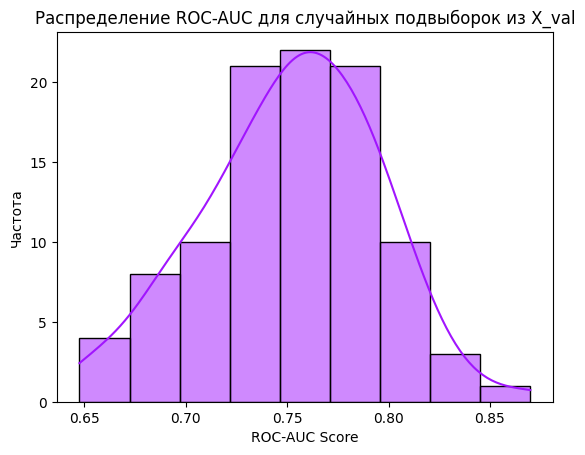

5-й квантиль: 0.6779855648101631
95-й квантиль: 0.8114331498878621


In [21]:
seed = 42
rng = np.random.RandomState(seed)

roc_auc_scores = []

for _ in range(100):  # Повторяем 100 раз
    # Выбираем случайные 1000 элементов из X_val и соответствующие метки y_val с помощью созданного генератора
    sample_indices = rng.choice(X_val.index, size=1000, replace=False)
    X_val_sample = X_val.loc[sample_indices]
    y_val_sample = y_val.loc[sample_indices]
    
    # Выполняем предсказание для выборки
    y_pred_sample = model.predict_proba(X_val_sample)[:, 1]
    
    # Вычисляем roc_auc и добавляем в список
    roc_auc = roc_auc_score(y_val_sample, y_pred_sample)
    roc_auc_scores.append(roc_auc)

# Визуализация распределения roc_auc с помощью гистограммы
sns.histplot(roc_auc_scores, kde=True)
plt.title('Распределение ROC-AUC для случайных подвыборок из X_val')
plt.xlabel('ROC-AUC Score')
plt.ylabel('Частота')
plt.show()

# Вычисление 5-го и 95-го квантилей
quantile_5 = np.percentile(roc_auc_scores, 5)
quantile_95 = np.percentile(roc_auc_scores, 95)

print(f"5-й квантиль: {quantile_5}")
print(f"95-й квантиль: {quantile_95}")

In [22]:
import pickle

#Сохранение модели
with open('catboost_model.pkl', 'wb') as f:
    pickle.dump(model, f)


with open('catboost_model.pkl', 'rb') as f:
    loaded_automl = pickle.load(f)


In [33]:
file_path = "Data/test_sber.parquet"
pf = ParquetFile(file_path)
df = pf.to_pandas()
id = df["id"].values
df = df[X_train.columns]
y_pred = model.predict_proba(df[X_train.columns])[:, 1]
predictions = np.where(y_pred > 0.03, 1, 0)
submit = pd.DataFrame({
    "id": id,
    "target_bin":predictions,
    "target_prob": y_pred
})
submit
submit.to_csv("submit_catboost.csv", index=False)

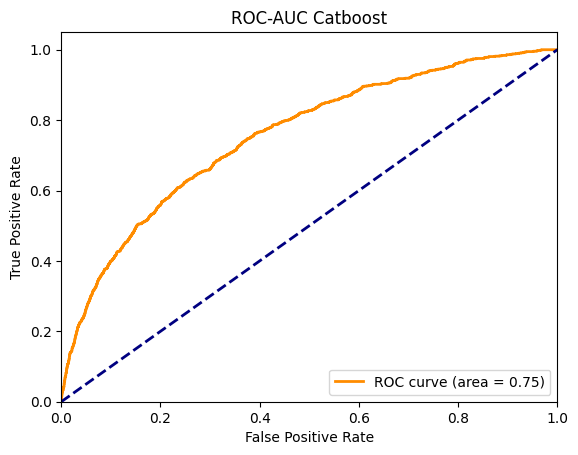

In [42]:
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred)

# Расчет площади под ROC-кривой (AUC)
roc_auc = auc(fpr, tpr)

# Построение ROC-кривой
plt.figure()
lw = 2  # Ширина линии
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC Catboost')
plt.legend(loc="lower right")
plt.show()

In [4]:
#Сохранение модели
import pickle
with open('catboost_model.pkl', 'rb') as f:
    catboost_model = pickle.load(f)
with open('automl_model_0.769.pkl', 'rb') as f:
    automl_model = pickle.load(f)

'nlp' extra dependecy package 'gensim' isn't installed. Look at README.md in repo 'LightAutoML' for installation instructions.
'nlp' extra dependecy package 'nltk' isn't installed. Look at README.md in repo 'LightAutoML' for installation instructions.
'nlp' extra dependecy package 'transformers' isn't installed. Look at README.md in repo 'LightAutoML' for installation instructions.


c:\Users\Александр\Desktop\УЧЕБА\ХАКАТОНЫ\IT Purple Hack\purple_hack\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


'nlp' extra dependecy package 'gensim' isn't installed. Look at README.md in repo 'LightAutoML' for installation instructions.
'nlp' extra dependecy package 'nltk' isn't installed. Look at README.md in repo 'LightAutoML' for installation instructions.
'nlp' extra dependecy package 'transformers' isn't installed. Look at README.md in repo 'LightAutoML' for installation instructions.


c:\Users\Александр\Desktop\УЧЕБА\ХАКАТОНЫ\IT Purple Hack\purple_hack\venv\Lib\site-packages\lightautoml\ml_algo\dl_model.py:42: UserWarning: 'transformers' - package isn't installed
  warnings.warn("'transformers' - package isn't installed")
c:\Users\Александр\Desktop\УЧЕБА\ХАКАТОНЫ\IT Purple Hack\purple_hack\venv\Lib\site-packages\lightautoml\text\embed.py:22: UserWarning: 'transformers' - package isn't installed
  warnings.warn("'transformers' - package isn't installed")
c:\Users\Александр\Desktop\УЧЕБА\ХАКАТОНЫ\IT Purple Hack\purple_hack\venv\Lib\site-packages\lightautoml\text\dl_transformers.py:25: UserWarning: 'transformers' - package isn't installed
  warnings.warn("'transformers' - package isn't installed")


In [28]:
# Используем предсказания моделей для формирования новых данных
catboost_pred_train = catboost_model.predict_proba(X_train)[:, 1]
auto_ml_train = automl_model.predict(X_train).data[:, 0]
train_data = pd.DataFrame({
    "catboost": catboost_pred_train,
    "automl": auto_ml_train,
    "target": y_train
})

catboost_pred_val = catboost_model.predict_proba(X_val)[:, 1]  # Исправлено на X_val
auto_ml_val = automl_model.predict(X_val).data[:, 0]   # Исправлено на X_val
val_data = pd.DataFrame({
    "catboost": catboost_pred_val,
    "automl": auto_ml_val,
    "target": y_val
})




In [30]:
catboost_pred_test = catboost_model.predict_proba(X_test)[:, 1]  # Исправлено на X_test
auto_ml_test = automl_model.predict(X_test).data[:, 0]  # Исправлено на X_test
test_data = pd.DataFrame({
    "catboost": catboost_pred_test,
    "automl": auto_ml_test,
    "target": y_test})

In [34]:
X_final_train = train_data.drop("target", axis=1)
y_final_train = train_data["target"]
X_final_val = val_data.drop("target", axis=1)
y_final_val = val_data["target"]
X_final_test = test_data.drop("target", axis=1)
y_final_test = test_data["target"]

In [38]:
final_model = CatBoostClassifier(**params)
final_model.fit(X_final_train, y_final_train, verbose = 50)

y_train_pred = final_model.predict_proba(X_final_train)[:, 1]
y_val_pred = final_model.predict_proba(X_final_val)[:, 1]


roc_auc_val = roc_auc_score(y_final_val, y_val_pred)
print(roc_auc_val)

0:	learn: 0.5371327	total: 50.2ms	remaining: 50.1s
50:	learn: 0.0953832	total: 2.05s	remaining: 38.1s
100:	learn: 0.0942408	total: 3.8s	remaining: 33.8s
150:	learn: 0.0939555	total: 5.46s	remaining: 30.6s
200:	learn: 0.0937827	total: 7.14s	remaining: 28.4s
250:	learn: 0.0936405	total: 8.87s	remaining: 26.4s
300:	learn: 0.0934989	total: 10.6s	remaining: 24.5s
350:	learn: 0.0933987	total: 12.3s	remaining: 22.7s
400:	learn: 0.0932921	total: 14s	remaining: 20.8s
450:	learn: 0.0932120	total: 15.6s	remaining: 19s
500:	learn: 0.0931110	total: 17.3s	remaining: 17.2s
550:	learn: 0.0930124	total: 18.9s	remaining: 15.4s
600:	learn: 0.0929090	total: 20.6s	remaining: 13.6s
650:	learn: 0.0928314	total: 22.2s	remaining: 11.8s
700:	learn: 0.0927525	total: 23.8s	remaining: 10.1s
750:	learn: 0.0926710	total: 25.5s	remaining: 8.41s
800:	learn: 0.0925946	total: 27s	remaining: 6.68s
850:	learn: 0.0925211	total: 28.7s	remaining: 4.99s
900:	learn: 0.0924525	total: 30.4s	remaining: 3.3s
950:	learn: 0.0923825	

In [41]:
file_path = "Data/test_sber.parquet"
pf = ParquetFile(file_path)
df = pf.to_pandas()
id = df["id"].values
df = df[X_train.columns]

In [45]:
lama_pred = automl_model.predict(df).data[:,0]
catboost_pred = catboost_model.predict_proba(df)[:, 1]
to_pred = pd.DataFrame({
    "catboost": catboost_pred,
    "automl": lama_pred})

y_pred = final_model.predict_proba(to_pred)[:, 1]
predictions = np.where(y_pred > 0.03, 1, 0)
submit = pd.DataFrame({
    "id": id,
    "target_bin":predictions,
    "target_prob": y_pred
})
submit
submit.to_csv("submit_catboost+lama.csv", index=False)

In [43]:
len(catboost_pred), len(lama_pred)

(173433, 173433)

In [44]:
catboost_pred

array([[0.98271996, 0.01728004],
       [0.98093175, 0.01906825],
       [0.96400901, 0.03599099],
       ...,
       [0.9052126 , 0.0947874 ],
       [0.88929508, 0.11070492],
       [0.92508849, 0.07491151]])